# Configuration

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
import plotly.express as px
import plotly.graph_objects as go

In [2]:
DISNEY_COLORS = {
    "blue": "#393e8f",
    "yellow":"#f3cc64",
    "red":"#b12228",
    "pink":"#efbeb7",
    "white":"#ffffff",
    "blue_oxford":"#12194a",
    }

# Customizing the default Matplotlib settings
plt.rcParams.update({
    "font.family": "Helvetica",             #!Set font to Helvetica
    "axes.titlesize": 16,                 # Title font size
    "axes.labelsize": 14,                 # Axis label font size
    "xtick.labelsize": 12,                # X tick label size
    "ytick.labelsize": 12,                # Y tick label size
    "axes.titleweight": "bold",           # Title weight
    "axes.labelweight": "bold",           # Axis label weight
    "axes.edgecolor": DISNEY_COLORS['blue_oxford'],  # Set axis edge color
    "axes.facecolor": DISNEY_COLORS['white'],        # Set background color of axes
    "grid.color": DISNEY_COLORS['blue_oxford'],      # Gridline color    'lines.linewidth': 2.5,                     # Line width globally set to 2.5
    'lines.linewidth': 2,                     # Line width globally set to 2.5
    "grid.linestyle": "--",                # Gridline style
    "legend.fontsize": 12,                 # Legend font size
    "text.color": DISNEY_COLORS['blue_oxford'],      # General text color
})

# Setting a custom color palette for Seaborn
sns.set_palette([DISNEY_COLORS["blue"], DISNEY_COLORS["yellow"], DISNEY_COLORS["red"], DISNEY_COLORS["pink"]])

# Optional: Customize Seaborn style
sns.set_style("whitegrid", {
    "axes.edgecolor": DISNEY_COLORS['blue_oxford'],
    "axes.facecolor": DISNEY_COLORS['white'],
    "grid.color": DISNEY_COLORS['blue_oxford'],
    "grid.linestyle": '--',
})

In [3]:

# Path to your SQL schema
sql_schema_path = '../sql_schema.sql'

# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Read the SQL schema and execute it
with open(sql_schema_path, 'r') as file:
    sql_schema = file.read()
    conn.executescript(sql_schema)

# List all tables in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, conn)

# Load each table into a DataFrame
dataframes = {}
for table in tables['name']:
    df = pd.read_sql(f'SELECT * FROM {table}', conn)
    dataframes[table] = df


In [4]:
table_a = dataframes["TABLE_A"]
table_b = dataframes["TABLE_B"]

table_a.to_excel("../table_a.xlsx", index=False)
table_b.to_excel("../table_b.xlsx", index=False)

# Data Wrangling

In [5]:
# Convert durations to minutes
df = dataframes["TABLE_A"]
df['title_name'] = np.where(df['PROGRAM_TYPE'] == 'movie', 
                               df['PROGRAM_FULL_TITLE'], 
                               df['SERIES_FULL_TITLE'])
df["START_DATE_EST"] = pd.to_datetime(df["START_DATE_EST"])
df = df[(df["START_DATE_EST"] >= "2021-06") & (df["PROGRAM_TYPE"].isin(["episode", "movie"]))
        & (df["IS_STREAM"] == 1)]
df['WATCH_LENGTH_MIN'] = df['WATCH_LENGTH_MS'] / 60000 #originally in miliseconds
df['RUNTIME_MIN'] = df['RUNTIME'] / 60 #originally in seconds
df['proportion'] = df['WATCH_LENGTH_MIN'] / df['RUNTIME_MIN']
df['rolling_mean'] = df.groupby('PROGRAM_TYPE')['proportion'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
grouped = df.groupby(['START_DATE_EST', 'PROGRAM_TYPE'])['proportion'].mean().reset_index()

C:\Users\marti\AppData\Local\Temp\ipykernel_18272\1385694914.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WATCH_LENGTH_MIN'] = df['WATCH_LENGTH_MS'] / 60000 #originally in miliseconds
C:\Users\marti\AppData\Local\Temp\ipykernel_18272\1385694914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RUNTIME_MIN'] = df['RUNTIME'] / 60 #originally in seconds
C:\Users\marti\AppData\Local\Temp\ipykernel_18272\1385694914.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\marti\AppData\Local\Temp\ipykernel_18272\1158014904.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='START_DATE_EST', y='rolling_mean', hue='PROGRAM_TYPE', ci=None)


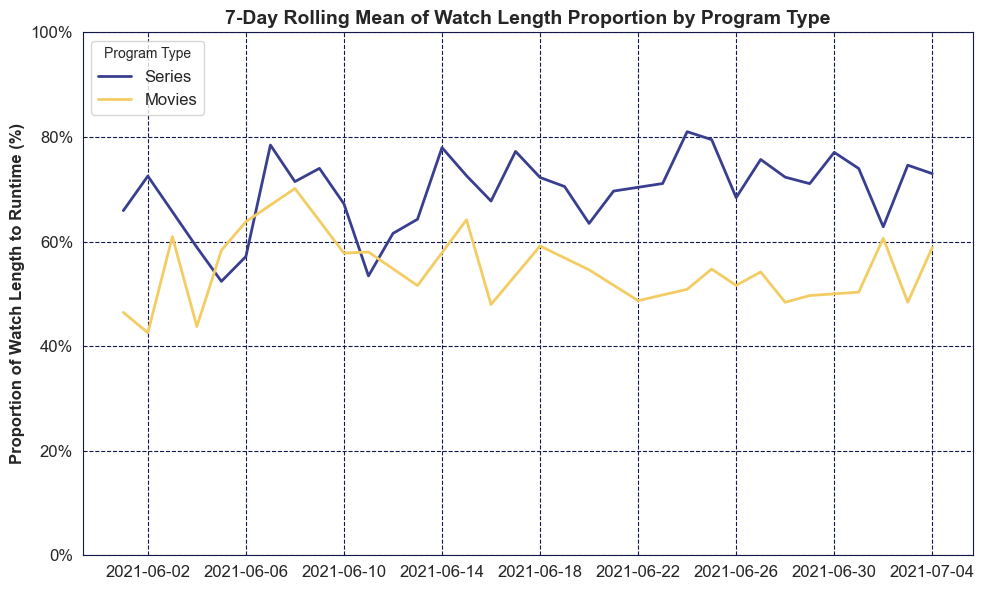

In [6]:
plt.figure(figsize=(10, 6))

# Create the line plot
sns.lineplot(data=df, x='START_DATE_EST', y='rolling_mean', hue='PROGRAM_TYPE', ci=None)

# Update the title
plt.title('7-Day Rolling Mean of Watch Length Proportion by Program Type', fontsize=14)

# Set axis labels
plt.xlabel('', fontsize=12)
plt.ylabel('Proportion of Watch Length to Runtime (%)', fontsize=12)
plt.ylim(0, 1)

# Set y-axis tick format to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))  # `1.0` means 100%

# Move legend to the top left corner
plt.legend(title='Program Type', loc='upper left')

# Replace legend labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label.replace("movie", "Movies").replace("episode", "Series") for label in labels]
plt.legend(handles, labels, title='Program Type', loc='upper left')

# Improve x-axis ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

# Grid and layout adjustments
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

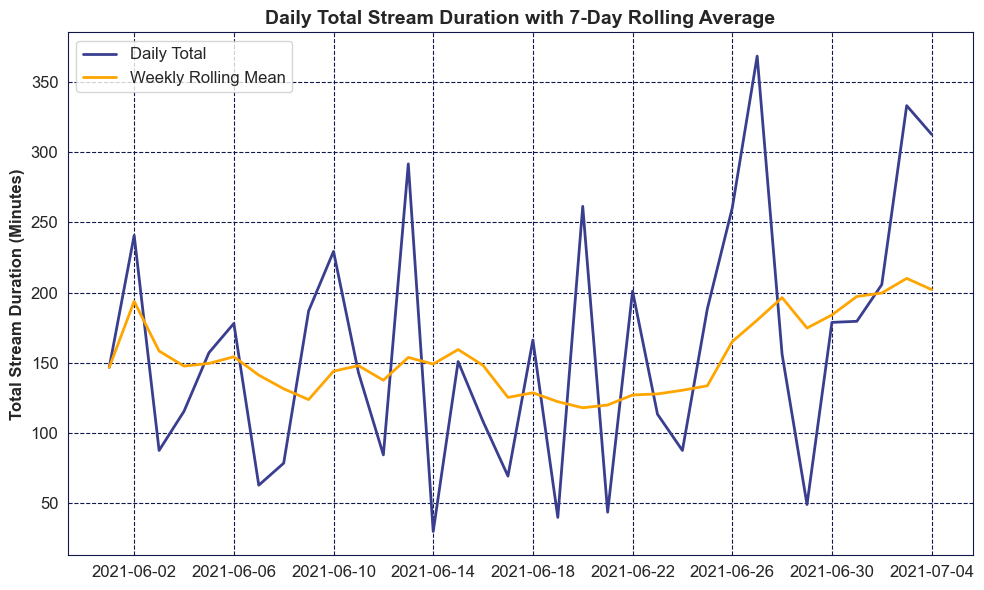

In [7]:
df_filtered = df.groupby('START_DATE_EST')['WATCH_LENGTH_MIN'].sum().reset_index()
df_filtered.set_index('START_DATE_EST', inplace=True)
df_filtered['rolling_mean'] = df_filtered['WATCH_LENGTH_MIN'].rolling(window=7, min_periods=1).mean()
df_filtered.reset_index(inplace=True)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x='START_DATE_EST', y='WATCH_LENGTH_MIN', label='Daily Total')
sns.lineplot(data=df_filtered, x='START_DATE_EST', y='rolling_mean', marker='', label='Weekly Rolling Mean', color='orange')
plt.title('Daily Total Stream Duration with 7-Day Rolling Average', fontsize=14)
plt.xlabel('', fontsize=10)
plt.ylabel('Total Stream Duration (Minutes)', fontsize=12)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


C:\Users\marti\AppData\Local\Temp\ipykernel_18272\2464976569.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_b["START_DATE"] = pd.to_datetime(table_b["START_DATE"])


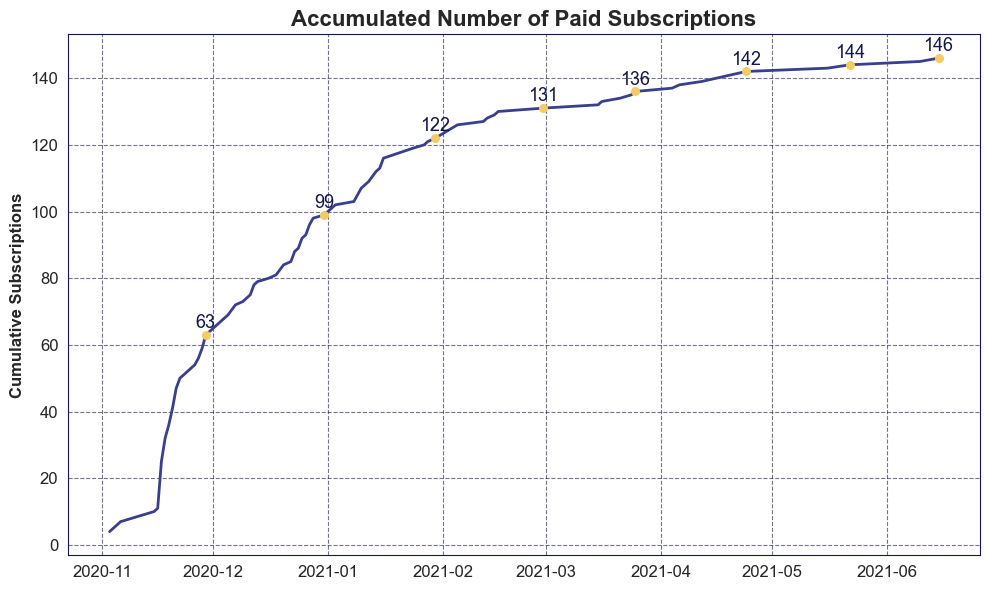

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming table_b is already filtered and loaded

# Step 1: Filter the data for the desired date range (2020-2022)
table_b = table_b[(table_b["START_DATE"] != "202-01-15")
                & (table_b["SUBSCRIPTION_STATE"] == "paid")] #error in data
# Convert START_DATE to datetime
table_b["START_DATE"] = pd.to_datetime(table_b["START_DATE"])


# Step 2: Group by START_DATE and count the number of subscriptions for each day
subscriptions_per_day = table_b.groupby("START_DATE").size().reset_index(name='daily_subscriptions')

# Step 3: Calculate the cumulative sum of subscriptions
subscriptions_per_day['cumulative_subscriptions'] = subscriptions_per_day['daily_subscriptions'].cumsum()

# Step 4: Identify the last observation at the end of each month
subscriptions_per_day['month'] = subscriptions_per_day['START_DATE'].dt.to_period('M')  # Extract month
end_of_month_points = subscriptions_per_day.groupby('month').last().reset_index()  # Get last available day for each month

# Step 5: Plot the cumulative subscriptions over time
plt.figure(figsize=(10, 6))

# Use the Disney blue color for the line
sns.lineplot(data=subscriptions_per_day, x='START_DATE', y='cumulative_subscriptions', color=DISNEY_COLORS['blue'])

# Add markers for the end of each month using the Disney red color
plt.scatter(end_of_month_points['START_DATE'], end_of_month_points['cumulative_subscriptions'], 
            color=DISNEY_COLORS['yellow'], s=30, zorder=5)

# Step 6: Add annotations for the cumulative subscriptions at the end of each month
for _, row in end_of_month_points.iterrows():
    plt.annotate(f"{row['cumulative_subscriptions']:.0f}",
                 (row['START_DATE'], row['cumulative_subscriptions']),
                 textcoords="offset points", xytext=(0, 5), ha='center', 
                 fontsize=13, color=DISNEY_COLORS['blue_oxford'])

# Step 7: Beautify the plot
plt.title('Accumulated Number of Paid Subscriptions', fontsize=16, fontweight='bold')
plt.xlabel('', fontsize=12, color=DISNEY_COLORS['blue_oxford'])
plt.ylabel('Cumulative Subscriptions', fontsize=12,)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjusting xticks (rotation if needed)
# plt.xticks(color=DISNEY_COLORS['blue_oxford'], fontsize=12)
# plt.yticks(color=DISNEY_COLORS['blue_oxford'], fontsize=12)

# Add tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
# Assuming df is already loaded and contains the necessary columns
df['WATCH_LENGTH_MIN'] = df['WATCH_LENGTH_MS'] / 60000  # Convert from milliseconds to minutes
df['RUNTIME_MIN'] = df['RUNTIME'] / 60  # Convert from seconds to minutes

# Filter for streams only
df = df[df["IS_STREAM"] == 1]

# Group by Title and Program Type, summing WATCH_LENGTH_MIN and RUNTIME_MIN
grouped = df.groupby(['PROGRAM_TYPE', 'PROGRAM_FULL_TITLE', 'SERIES_FULL_TITLE'], as_index=False).agg(
    total_watch_length=('WATCH_LENGTH_MIN', 'sum'),
    total_runtime=('RUNTIME_MIN', 'sum')
)

# Calculate the proportion for each title
grouped['proportion'] = grouped['total_watch_length'] / grouped['total_runtime']

# Create a new DataFrame for box plot
box_data = pd.DataFrame()

# For movies
movies = grouped[grouped['PROGRAM_TYPE'] == 'movie'].copy()
movies['Title'] = movies['PROGRAM_FULL_TITLE']
movies['Type'] = 'Movies'

# For series
series = grouped[grouped['PROGRAM_TYPE'] == 'episode'].copy()
series['Title'] = series['SERIES_FULL_TITLE']
series['Type'] = 'Series'

# Combine both DataFrames
box_data = pd.concat([movies[['Title', 'proportion', 'Type']],
                      series[['Title', 'proportion', 'Type']]], ignore_index=True)

# Create the box plot with hover data
fig = px.box(
    box_data,
    x='Type',
    y='proportion',
    title='Proportion of Watch Length to Runtime by Type',
    labels={'Type': 'Type (Movies / Series)', 'proportion': 'Proportion (Watch Length / Runtime)'},
    hover_data=['Title']  # Add title to hover information
)

fig = px.box(
    box_data,
    x='Type',
    y='proportion',
    title='<b>Proportion of Watch Length to Runtime by Program Type',
    labels={'Type': 'Type (Movies / Series)', 'proportion': 'Proportion (Watch Length / Runtime)'},
    hover_data=['Title'],  # Add title to hover information
    color='Type',  # Use 'Type' for color differentiation
    color_discrete_map={'Movies': DISNEY_COLORS['blue'], 'Series': DISNEY_COLORS['yellow']}  # Set colors based on the dictionary
)

# Add scatter points (jitter) with hover data
# Create the box plot with hover data
fig = px.box(
    box_data,
    x='Type',
    y='proportion',
    title='<b>Proportion of Watch Length to Runtime by Type</b>',
    labels={'Type': 'Type (Movies / Series)', 'proportion': 'Proportion (Watch Length / Runtime)'},
    hover_data=['Title'],  # Add title to hover information
    color='Type',  # Use 'Type' for color differentiation
    color_discrete_map={'Movies': DISNEY_COLORS['yellow'], 'Series': DISNEY_COLORS['blue']}  # Set colors based on the dictionary
)

# Add scatter points (jitter) with hover data
scatter = px.strip(box_data, x='Type', y='proportion', hover_data=['Title'], color='Type',
                   color_discrete_map={'Movies': DISNEY_COLORS['yellow'], 'Series': DISNEY_COLORS['blue']})
fig.add_traces(scatter.data)

fig.add_shape(
    type="rect",
    x0=-0.5, x1=1.5, y0=1, y1=box_data['proportion'].max(),
    fillcolor="rgba(255, 0, 0, 0.2)",  # Light red fill
    line=dict(width=0)  # No border
)
# Add a horizontal line at y=1
fig.add_shape(
    type='line',
    x0=-0.5,  # Start of line (slightly before the first category on x-axis)
    x1=1.5,    # End of line (slightly after the second category on x-axis)
    y0=1,
    y1=1,
    line=dict(color=DISNEY_COLORS["red"], width=2, dash='dash'),
)

# Add annotation for the "Bad Input Data"
fig.add_annotation(
    text="Outliers",
    xref="paper", yref="y",
    x=1, y=1.05,  # Adjust x and y positions for annotation
    showarrow=False,
    font=dict(size=12, color=DISNEY_COLORS["red"]),
    bgcolor="white",
    bordercolor=DISNEY_COLORS["red"]
)

# Fill the area above the threshold with a light red color

# Update layout with Helvetica font and legend position
fig.update_layout(
    title_font=dict(family='Helvetica', size=14),
    font=dict(family='Helvetica'),  # Set font for all text
    showlegend=False,
    # title_x=0.5,  # Center title horizontally
    title_y=0.8,  # Adjust vertical position to reduce distance from plot
)

# Update y-axis to display percentage format
fig.update_yaxes(tickformat=".0%")
fig.update_xaxes(title_text = "")
fig.update_layout(template=None, margin = {"t":100, "b":30}, height = 500, width = 700)

C:\Users\marti\AppData\Local\Temp\ipykernel_18272\4110204119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WATCH_LENGTH_MIN'] = df['WATCH_LENGTH_MS'] / 60000  # Convert from milliseconds to minutes
C:\Users\marti\AppData\Local\Temp\ipykernel_18272\4110204119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RUNTIME_MIN'] = df['RUNTIME'] / 60  # Convert from seconds to minutes


In [10]:
box_data.sort_values("proportion")

,Title,proportion,Type
5,Cinderella,0.002826,Movies
9,Finding Dory,0.002832,Movies
10,Finding Nemo,0.004139,Movies
77,Big Shot,0.006367,Series
34,"The Chronicles of Narnia: The Lion, the Witch ...",0.009672,Movies
...,...,...,...
31,Star Wars: A New Hope (Episode IV),0.996218,Movies
42,X2,0.998430,Movies
71,Science of Stupid,0.999856,Series
140,Big City Greens,1.000559,Series


In [11]:
df_filtered = df[df['IS_STREAM'] == 1]

# Group by 'title_name' (assuming this is the program title) and 'PROGRAM_TYPE'
result = df_filtered.groupby(['title_name', 'PROGRAM_TYPE']).agg(
    Unique_Account_Count=('ACCOUNT_ID', 'nunique'),
    Total_Completed_Streams=('IS_COMPLETED_STREAM', 'sum'),
    Total_Watch_Length_Min=('WATCH_LENGTH_MIN', 'sum'),
    Total_Runtime_Min=('RUNTIME_MIN', 'sum')
).reset_index()

# Rename the columns for clarity
result.columns = ['Program Title', 'Program Type', 'Unique Account Count', 
                  'Total Completed Streams', 'Total Watch Length (Min)', 'Total Runtime (Min)']

result["proportion_time"] = result['Total Watch Length (Min)'] / result['Total Runtime (Min)']
result["proportion_completed"] = result['Total Completed Streams'] / result['Unique Account Count']

result = result.sort_values(["Unique Account Count", "proportion_time"], ascending=False)
result

,Program Title,Program Type,Unique Account Count,Total Completed Streams,Total Watch Length (Min),Total Runtime (Min),proportion_time,proportion_completed
36,Loki,episode,17,12,651.402767,839.766667,0.775695,0.705882
33,Jessie,episode,10,5,144.284067,245.000000,0.588915,0.500000
37,Luca,movie,7,4,387.637583,707.233333,0.548104,0.571429
88,The Mandalorian,episode,5,3,88.699333,215.716667,0.411184,0.600000
26,Girl Meets World,episode,4,4,76.179983,96.633333,0.788341,1.000000
...,...,...,...,...,...,...,...,...
83,"The Chronicles of Narnia: The Lion, the Witch ...",movie,1,0,1.421117,146.933333,0.009672,0.000000
9,Big Shot,episode,1,0,0.295017,46.333333,0.006367,0.000000
22,Finding Nemo,movie,1,0,0.418750,101.183333,0.004139,0.000000
21,Finding Dory,movie,1,0,0.274767,97.016667,0.002832,0.000000
